In [2]:
import pandas as pd
import numpy as np
import graphviz

In [3]:
datapath = 'data/'
demo = pd.read_csv(datapath + 'Demographics.csv')
icd = pd.read_csv(datapath + 'ICD.csv')
lab = pd.read_csv(datapath + 'LABS.csv')
vitals = pd.read_csv(datapath + 'Vitals.csv')
inpmed = pd.read_csv(datapath + 'INP_MED.csv')
outmed = pd.read_csv(datapath + 'OUT_MED.csv')
label = pd.read_csv(datapath + 'Labels.csv')

# Check consistency

In [4]:
print(label[label['split'] == 'val'])

      Unnamed: 0   idx  label       pe_type split
2              2  2738      0           NaN   val
11            11  2000      1       central   val
37            37   781      1       central   val
52            52   288      1  subsegmental   val
68            68   315      0           NaN   val
...          ...   ...    ...           ...   ...
1810        1810  1911      0           NaN   val
1822        1822  1425      0           NaN   val
1823        1823  1893      1     segmental   val
1829        1829   128      1       central   val
1833        1833   127      0           NaN   val

[193 rows x 5 columns]


In [5]:
print(demo[demo['idx'] == 2738])

    current_age_yrs  Female  Male  Asian  Black  Native American  Other  \
37            78.95       1     0      0      0                0      0   

    Pacific Islander  Unknown_race  White  SMOKER_N  SMOKER_Y   idx split  
37                 0             1      0         1         0  2738   val  


# Combine

In [6]:
combined_df = demo

for df in [icd, lab, vitals, label, inpmed, outmed]:
    combined_df = combined_df.merge(df, on='idx', how='outer', suffixes=('', '_duplicate'))

columns_to_drop = [col for col in combined_df.columns if '_duplicate' in col]
combined_df.drop(columns=columns_to_drop, inplace=True)

In [7]:
combined_df

,current_age_yrs,Female,Male,Asian,Black,Native American,Other,Pacific Islander,Unknown_race,White,...,Outpatient_LHRH(GNRH)AGNST PIT.SUP-CENTRAL PRECOCIOUS PUBERTY:Frequeny,Outpatient_THROMBOLYTIC - NUCLEOTIDE TYPE:Frequeny,Outpatient_SELECTIVE SEROTONIN 5-HT2A INVERSE AGONISTS (SSIA):Frequeny,Outpatient_ANTINEOPLASTIC - HEDGEHOG PATHWAY INHIBITOR:Frequeny,Outpatient_ORGAN TRANSPLANTATION PRESERVATION SOLUTIONS:Frequeny,Outpatient_FEEDING DEVICES:Frequeny,"Outpatient_DRUGS TO TX GAUCHER DX-TYPE 1, SUBSTRATE REDUCING:Frequeny","Outpatient_TOPICAL PREPARATIONS,NON-MEDICINAL:Frequeny","Outpatient_ANTI-INFLAMMATORY, INTERLEUKIN-1 BETA BLOCKERS:Frequeny","Outpatient_ACNE AGENTS,SYSTEMIC:Frequeny"
0,80.00,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,64.12,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,93.42,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,93.82,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,71.78,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257,81.29,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4258,81.29,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4259,81.29,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4260,81.29,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
non_integer_columns = combined_df.columns[combined_df.applymap(lambda x: not isinstance(x, (int, float))).any()]
print(non_integer_columns)

Index(['split', 'pe_type'], dtype='object')


In [9]:
split_label = combined_df[['idx', 'pe_type', 'split']]


# PCA

In [10]:
pcadata = combined_df.drop(columns=['pe_type', 'split'])

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [12]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pcadata)

pca = PCA()
pca.fit(scaled_data)

loadings = pca.components_.T
feature_importances = (loadings ** 2).sum(axis=1)
top_features_idx = feature_importances.argsort()[::-1][:200]
df_top_features = pcadata.iloc[:, top_features_idx]

In [13]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pcadata)

pca = PCA()
principal_components = pca.fit_transform(scaled_data)

In [14]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

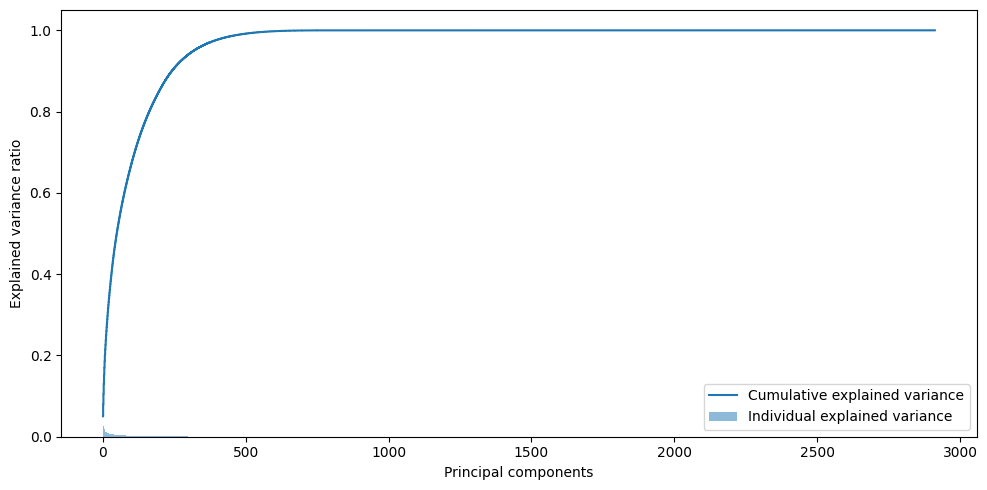

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# Plotting individual explained variance
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(len(cumulative_variance)), cumulative_variance, where='mid', label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [16]:
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, len(pca.explained_variance_)+1)])

In [17]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC2904,PC2905,PC2906,PC2907,PC2908,PC2909,PC2910,PC2911,PC2912,PC2913
0,17.097325,7.641927,0.533709,-5.907475,-1.285043,6.153636,1.301839,-1.628554,-4.558714,9.044674,...,-2.130916e-18,-8.114878e-19,-1.906705e-18,-4.451614e-19,-1.691966e-18,2.787999e-19,2.394379e-19,1.448225e-19,1.187687e-19,-9.329431e-20
1,-8.396764,-1.447397,0.988547,-0.385877,1.867741,-0.168004,-1.041959,-0.557644,-0.797503,-1.938291,...,-1.747278e-17,-1.151972e-17,-3.431054e-17,1.971290e-17,9.490557e-18,-9.272716e-18,1.454635e-17,-1.898253e-18,-3.134921e-18,4.830946e-18
2,-4.905358,0.520423,0.336167,-1.095286,0.420959,-0.801398,-0.603331,0.407507,0.179527,0.833639,...,2.035141e-17,-9.070230e-19,3.628396e-17,-7.475951e-19,6.451994e-19,3.896582e-18,-3.969265e-18,-1.611076e-18,2.933449e-18,6.066994e-19
3,-7.300688,-0.905922,0.787745,-0.529478,1.438142,0.141928,-0.385910,-0.350930,-0.481913,-0.796252,...,-7.811128e-18,-2.788681e-17,-2.406175e-17,-2.427867e-17,1.787078e-18,2.716795e-18,-3.562210e-18,-4.794698e-18,5.567068e-19,-1.560329e-18
4,-8.231640,-1.060502,0.808289,-0.351696,1.779599,0.322029,-0.550090,-0.366957,-0.890611,-1.538282,...,-2.262224e-17,-7.748824e-17,-6.001485e-17,-2.110831e-19,-3.848324e-18,-5.281873e-18,4.521327e-18,4.845232e-19,-1.520127e-18,4.693363e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257,-5.885670,-0.379419,0.559674,-0.849048,0.950462,0.088025,-0.050225,0.204485,-0.239207,-0.052659,...,-6.037712e-17,3.659381e-17,-3.201277e-17,5.325079e-17,-4.713359e-18,2.061821e-17,1.385418e-17,-1.759010e-17,-1.047412e-18,6.086172e-18
4258,-5.885670,-0.379419,0.559674,-0.849048,0.950462,0.088025,-0.050225,0.204485,-0.239207,-0.052659,...,-6.037712e-17,3.659381e-17,-3.201277e-17,5.325079e-17,-4.713359e-18,2.061821e-17,1.385418e-17,-1.759010e-17,-1.047412e-18,6.086172e-18
4259,-5.885670,-0.379419,0.559674,-0.849048,0.950462,0.088025,-0.050225,0.204485,-0.239207,-0.052659,...,4.956124e-17,-3.748915e-17,-5.255465e-17,-1.039009e-16,1.417734e-16,-2.426145e-16,-1.177974e-16,-1.158963e-17,-2.232152e-17,3.212981e-17
4260,-5.885670,-0.379419,0.559674,-0.849048,0.950462,0.088025,-0.050225,0.204485,-0.239207,-0.052659,...,7.464443e-17,-1.976730e-16,-9.900423e-17,-5.369880e-17,1.058982e-17,-1.059098e-16,-1.112056e-16,1.196240e-16,2.351697e-17,-3.774871e-17


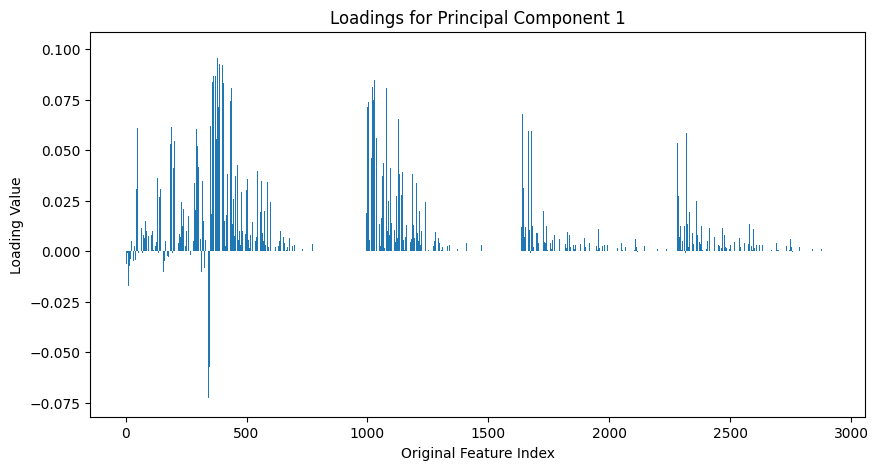

In [18]:
loadings = pca.components_
plt.figure(figsize=(10,5))
plt.bar(range(len(loadings[0])), loadings[0])
plt.xlabel('Original Feature Index')
plt.ylabel('Loading Value')
plt.title('Loadings for Principal Component 1')
plt.show()

# Train

In [19]:
pe_type_mapping = {
    'segmental': 1,
    'central': 1,
    'subsegmental': 1
}

split_label.loc[:, 'pe_type'] = split_label['pe_type'].replace(pe_type_mapping)
split_label['pe_type'].fillna(0, inplace=True)

C:\Users\cheek\AppData\Local\Temp\ipykernel_30276\3768595702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_label.loc[:, 'pe_type'] = split_label['pe_type'].replace(pe_type_mapping)
C:\Users\cheek\AppData\Local\Temp\ipykernel_30276\3768595702.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  split_label.loc[:, 'pe_type'] = split_label['pe_type'].replace(pe_type_mapping)
C:\Users\cheek\AppData\Local\Temp\ipykernel_30276\3768595702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [20]:
X_train = df_top_features[split_label['split'] == 'train']
y_train = split_label[split_label['split'] == 'train']['pe_type']

X_val = df_top_features[split_label['split'] == 'val']
y_val = split_label[split_label['split'] == 'val']['pe_type']

X_test = df_top_features[split_label['split'] == 'test']
y_test = split_label[split_label['split'] == 'test']['pe_type']

In [21]:
print(y_train.value_counts())


0.0    2025
1.0     967
Name: pe_type, dtype: int64


In [22]:
offending_columns = [col for col in X_train.columns if any(char in col for char in ['[', ']', '<'])]

print(offending_columns)

X_train = X_train.rename(columns={col: col.replace('[', '').replace(']', '').replace('<', '') for col in offending_columns})
X_val = X_val.rename(columns={col: col.replace('[', '').replace(']', '').replace('<', '') for col in offending_columns})


[]


In [23]:
from catboost import CatBoostClassifier, Pool

In [24]:
train_data = Pool(data=X_train, label=y_train)
val_data = Pool(data=X_val, label=y_val)

params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'verbose': 10
}

train_data = Pool(data=X_train, label=y_train)
val_data = Pool(data=X_val, label=y_val)

model = CatBoostClassifier(**params)
model.fit(train_data, eval_set=[val_data], early_stopping_rounds=10)

0:	learn: 0.5850220	test: 0.6560484	best: 0.6560484 (0)	total: 150ms	remaining: 14.8s
10:	learn: 0.2345762	test: 0.5514443	best: 0.5378285 (5)	total: 175ms	remaining: 1.42s
20:	learn: 0.1834030	test: 0.5619286	best: 0.5300331 (13)	total: 201ms	remaining: 755ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.5300331034
bestIteration = 13

Shrink model to first 14 iterations.


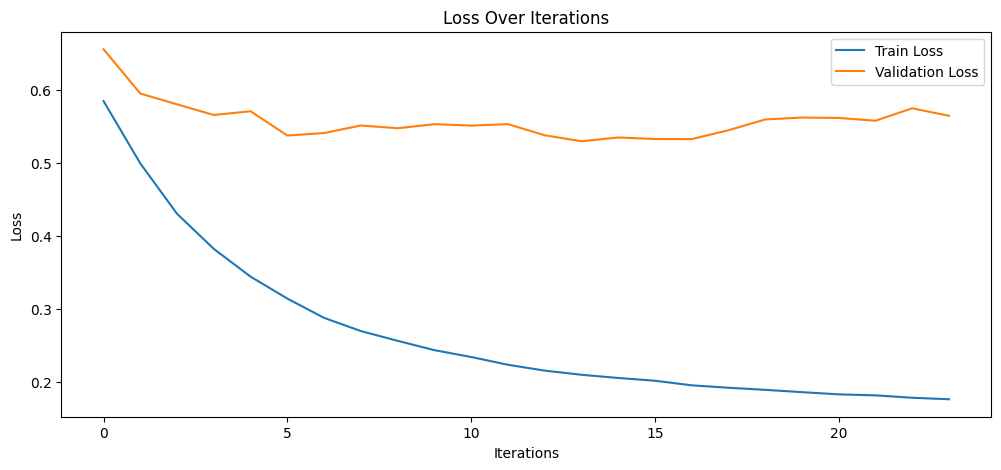

In [25]:
import matplotlib.pyplot as plt

train_loss = model.get_evals_result()['learn']['Logloss']
val_loss = model.get_evals_result()['validation']['Logloss']

plt.figure(figsize=(12, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Iterations")
plt.show()

In [26]:
from sklearn.metrics import accuracy_score

train_preds = model.predict(X_train).reshape(-1)
val_preds = model.predict(X_val).reshape(-1)

train_accuracy = accuracy_score(y_train, train_preds)
val_accuracy = accuracy_score(y_val, val_preds)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Training Accuracy: 94.15%
Validation Accuracy: 90.64%


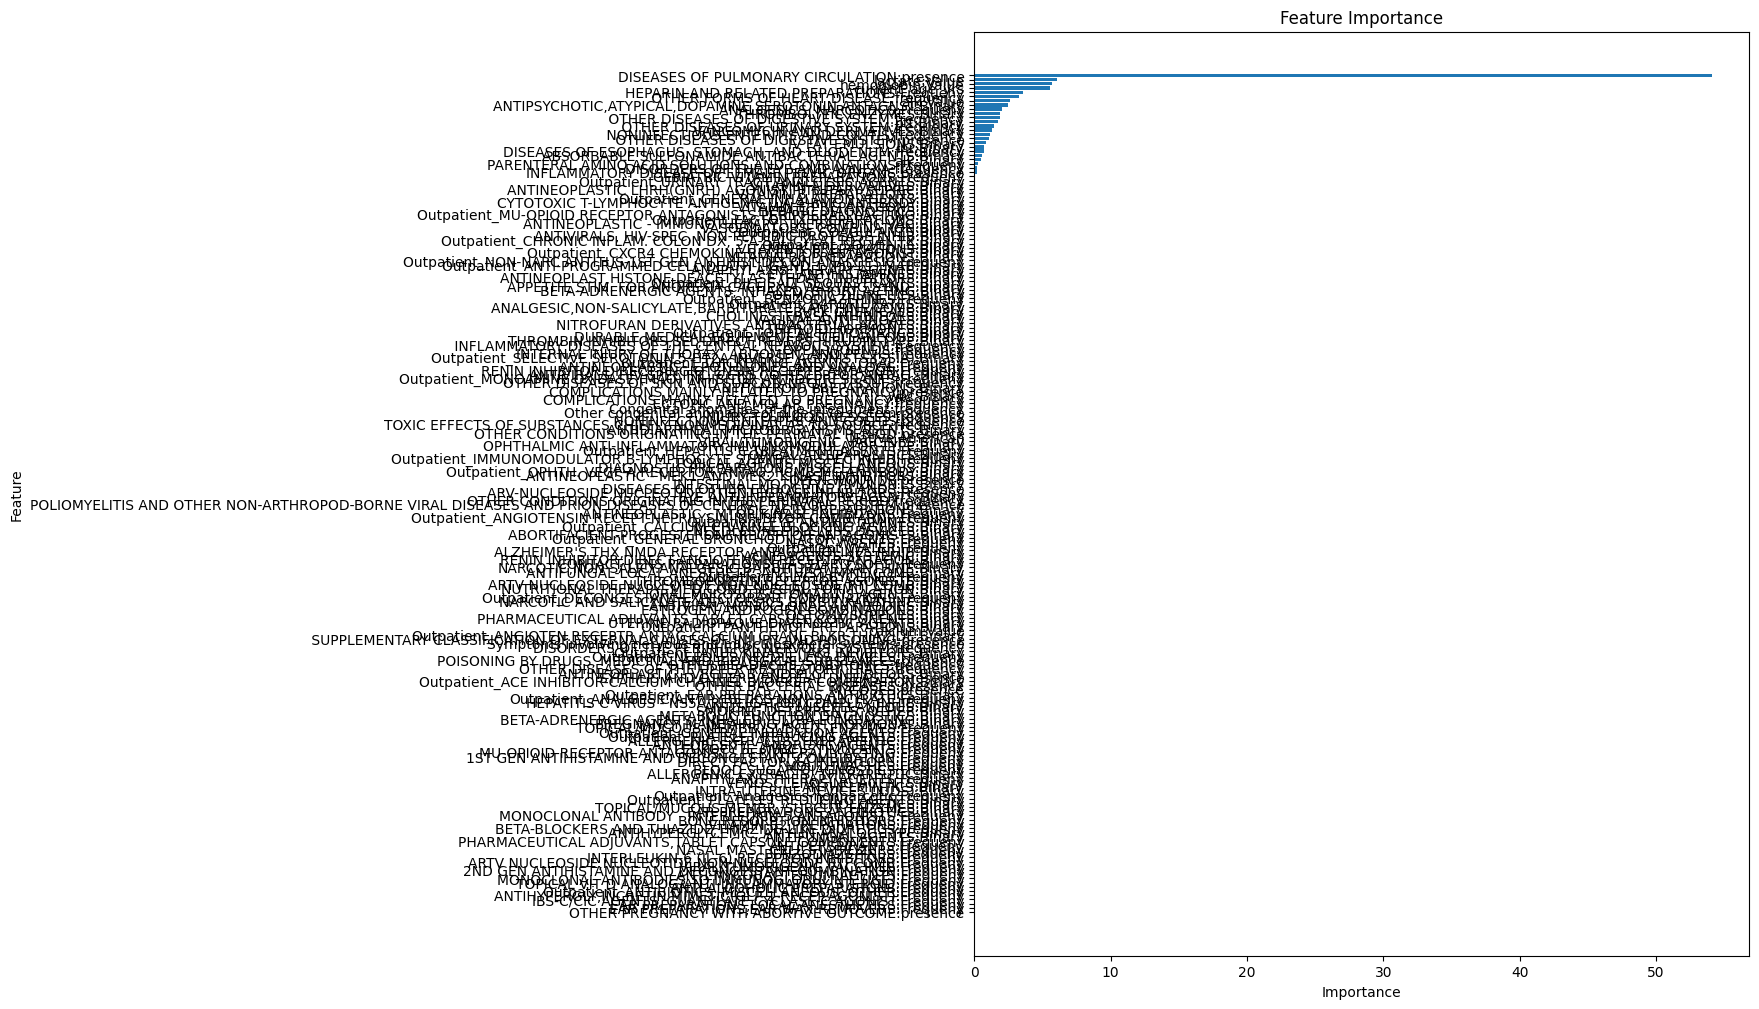

In [27]:
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

sorted_idx = feature_importances.argsort()
feature_names_sorted = feature_names[sorted_idx]
feature_importances_sorted = feature_importances[sorted_idx]

plt.figure(figsize=(10, 12))
plt.barh(feature_names_sorted, feature_importances_sorted)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

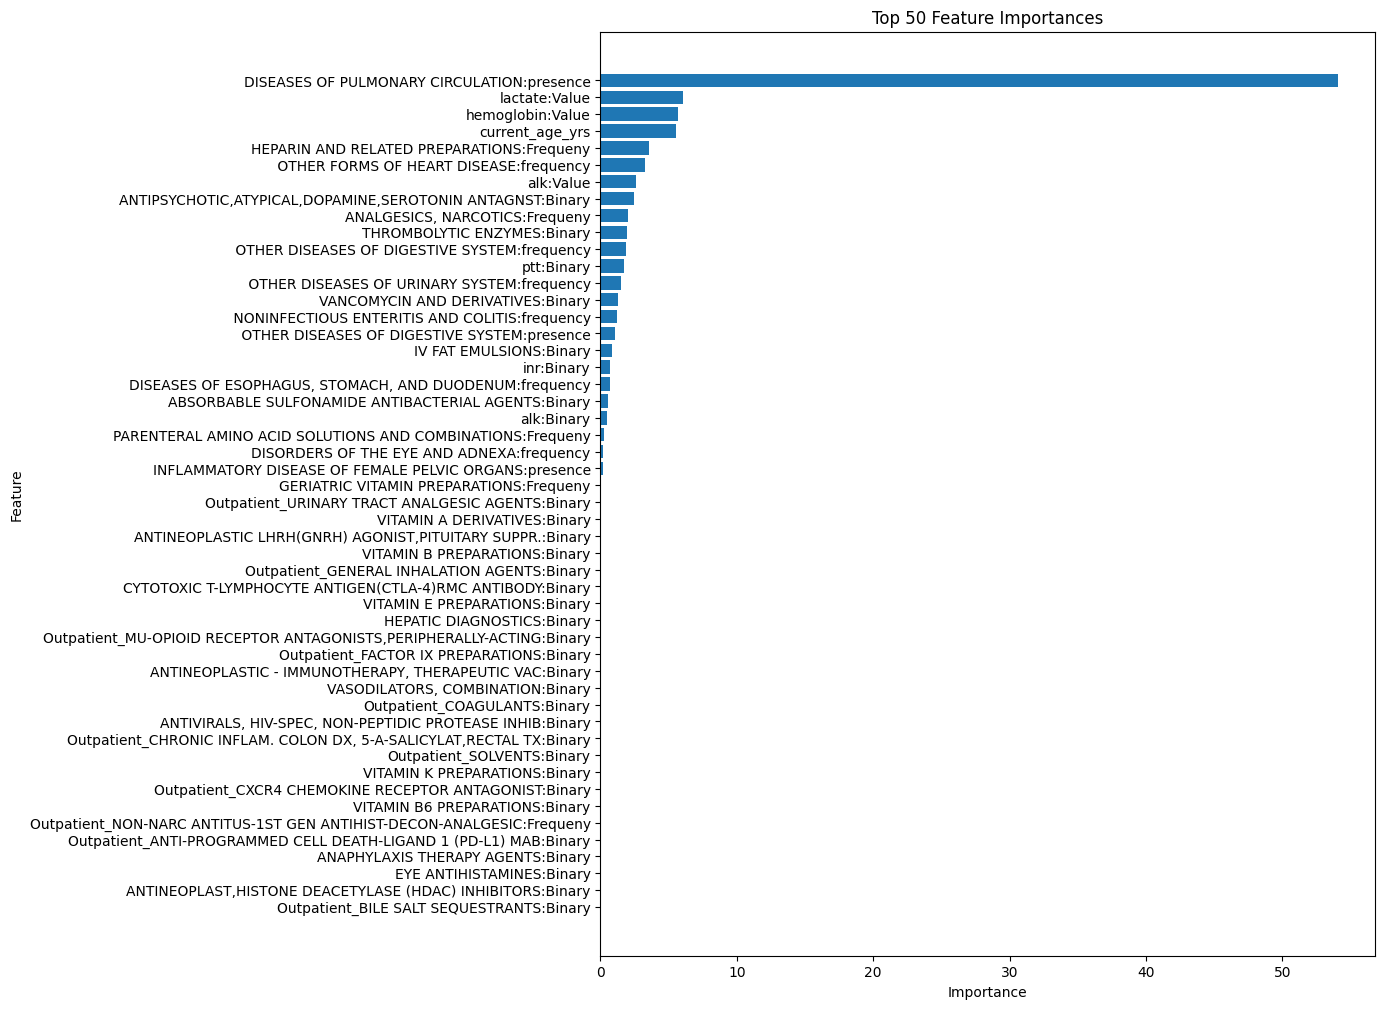

In [28]:
sorted_idx = feature_importances.argsort()[-50:]
feature_names_sorted = feature_names[sorted_idx]
feature_importances_sorted = feature_importances[sorted_idx]

# Plot
plt.figure(figsize=(10, 12))
plt.barh(feature_names_sorted, feature_importances_sorted)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 50 Feature Importances')
plt.show()

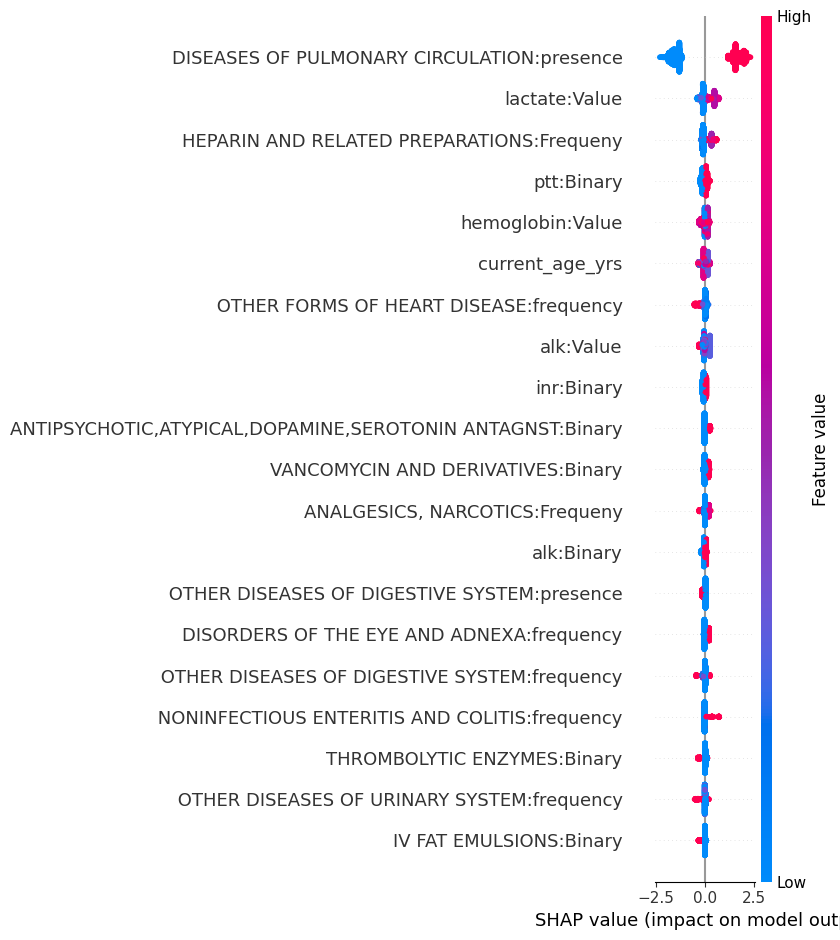

In [29]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

In [30]:
data_pool = Pool(data=X_train, label=y_train)
model.plot_tree(
    tree_idx=0,
    pool=data_pool
)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH